# Reverse checking ROC analysis

So in the notebook `ROC analysis on BayesDel data.ipynb` we took a look at classifying mutations based on BayesDel data. Then we took these classified datasets and tried to measure how well mechanistic models predict whether a mutation is benign or deleterious based on this dataset.

I thought that it would also be useful to try this the other way round. In the previous notebook, we saw that `average_energy = 2.4` kcal/mol was the optimal threshold for a BayesDel cutoff of -0.057, which is about what we expect.

But then when we calculate the fractions of deleterious / benign mutations which remain when we apply these cutoffs, we find that only 50% of the deleterious mutations remain. In other words if our statistical scores predict that a mutation is deleterious, there's only a 50% chance that our mechanistic model predicts the same thing. In comparison, if our statistical score suggests a mutationis benign, there's a 95% chance our mechanistic model predicts the same thing. Conditional probabilities.

In [1]:
import pandas as pd
import scipy.stats
import re

import matplotlib.pyplot as plt
import matplotlib
import seaborn as sns

from sklearn.metrics import roc_curve, auc, roc_auc_score
import numpy as np

from sklearn.metrics import confusion_matrix

import matplotlib.style #Some style nonsense
import matplotlib as mpl #Some more style nonsense

mpl.rcParams["legend.frameon"] = False
mpl.rcParams['figure.dpi']=300 # dots per inch

In [2]:
calculatedProperties = pd.read_csv("FH_complete_mutation_summary.csv")
calculatedProperties.head()

,Unnamed: 0,Residue,AAfrom,AAto,rhapsodyscore,rhapsodyclass,polyphenscore,polyphenclass,Foldx_energy,Rosetta_energy,Mutation,average_energy,RSA,Mindist_bindingsiteA,Mindist_hinge
0,0,49,S,A,0.086,neutral,0.00,neutral,0.061363,3.265,S49A,1.663182,0.992308,23.461148,33.7131
1,1,49,S,C,0.535,neutral,0.86,deleterious,0.067352,7.990,S49C,4.028676,0.992308,23.461148,33.7131
2,2,49,S,D,0.052,neutral,0.00,neutral,-0.103203,1.891,S49D,0.893899,0.992308,23.461148,33.7131
3,3,49,S,E,0.049,neutral,0.00,neutral,-0.086741,0.983,S49E,0.448129,0.992308,23.461148,33.7131
4,4,49,S,F,0.529,neutral,0.62,deleterious,0.182080,4.837,S49F,2.509540,0.992308,23.461148,33.7131


In [3]:
calculatedProperties = calculatedProperties.drop(columns = ["Mutation","Unnamed: 0", "rhapsodyclass","rhapsodyscore","polyphenscore","polyphenclass"])
calculatedProperties

,Residue,AAfrom,AAto,Foldx_energy,Rosetta_energy,average_energy,RSA,Mindist_bindingsiteA,Mindist_hinge
0,49,S,A,0.061363,3.265,1.663182,0.992308,23.461148,33.713100
1,49,S,C,0.067352,7.990,4.028676,0.992308,23.461148,33.713100
2,49,S,D,-0.103203,1.891,0.893899,0.992308,23.461148,33.713100
3,49,S,E,-0.086741,0.983,0.448129,0.992308,23.461148,33.713100
4,49,S,F,0.182080,4.837,2.509540,0.992308,23.461148,33.713100
...,...,...,...,...,...,...,...,...,...
8773,510,K,S,0.571362,1.871,1.221181,0.717073,14.891393,15.359364
8774,510,K,T,0.862076,1.330,1.096038,0.717073,14.891393,15.359364
8775,510,K,V,1.125190,-0.576,0.274595,0.717073,14.891393,15.359364
8776,510,K,W,0.686269,-0.158,0.264134,0.717073,14.891393,15.359364


In [4]:
BayesDel = pd.read_csv("./FH_mutations_BayesDel_Cleaned_2.csv")

In [5]:
# need to match column names to that of calculatedProperties
BayesDel.rename(columns={
    'aapos': 'Residue',
    'aaalt': 'AAto',
    'aaref': 'AAfrom'
}, inplace=True)

BayesDel.head()

,#chr,pos(1-based),ref,alt,genename,rs_dbSNP,AAfrom,AAto,Residue,HGVSc_VEP,HGVSp_VEP,BayesDel_addAF_score,BayesDel_noAF_score,BayesDel_addAF_rankscore
0,1,241497828,T,A,FH,.,X,C,511,c.1533A>T,p.Ter511CysextTer3,0.016367,-0.214267,0.53578
1,1,241497828,T,C,FH,.,X,W,511,c.1533A>G,p.Ter511TrpextTer3,0.048540,-0.168052,0.57861
2,1,241497828,T,G,FH,.,X,C,511,c.1533A>C,p.Ter511CysextTer3,0.019965,-0.209098,0.54067
3,1,241497829,C,A,FH,.,X,L,511,c.1532G>T,p.Ter511LeuextTer3,-0.136883,-0.434399,0.30031
4,1,241497829,C,G,FH,rs2147911168,X,S,511,c.1532G>C,p.Ter511SerextTer3,-0.148895,-0.451654,0.28133


In [6]:
# there's only some tables I want to keep
BayesDel = BayesDel[["AAfrom","AAto","Residue","BayesDel_addAF_score","BayesDel_noAF_score","BayesDel_addAF_rankscore"]]

In [7]:
BayesDel.head()

,AAfrom,AAto,Residue,BayesDel_addAF_score,BayesDel_noAF_score,BayesDel_addAF_rankscore
0,X,C,511,0.016367,-0.214267,0.53578
1,X,W,511,0.048540,-0.168052,0.57861
2,X,C,511,0.019965,-0.209098,0.54067
3,X,L,511,-0.136883,-0.434399,0.30031
4,X,S,511,-0.148895,-0.451654,0.28133


In [8]:
calc_benign = calculatedProperties[calculatedProperties['average_energy'] <= 2.4]
calc_deleterious = calculatedProperties[calculatedProperties['average_energy'] >= 2.4]

In [9]:
# converting tables to string to avoid potential errors
BayesDel = BayesDel.astype(str)
calc_benign = calc_benign.astype(str)
calc_deleterious = calc_deleterious.astype(str)

In [10]:
# merging datasets to get ready for binary classification
bs_calc = calc_benign.merge(BayesDel, on = ["Residue", "AAfrom", "AAto"])
ds_calc = calc_deleterious.merge(BayesDel, on = ["Residue", "AAfrom", "AAto"])

In [11]:
# add source column to benign and deleterious tables for classification
bs_calc["source"] = "neutral"
ds_calc["source"] = "deleterious"

In [12]:
logreg_data = pd.concat([bs_calc, ds_calc])

logreg_data = pd.get_dummies(logreg_data, columns = ["source"], drop_first = False)

logreg_data

,Residue,AAfrom,AAto,Foldx_energy,Rosetta_energy,average_energy,RSA,Mindist_bindingsiteA,Mindist_hinge,BayesDel_addAF_score,BayesDel_noAF_score,BayesDel_addAF_rankscore,source_deleterious,source_neutral
0,49,S,A,0.0613632,3.265,1.6631816,0.992307692,23.46114822,33.71310025,0.0169333,-0.213453,0.53653,0,1
1,49,S,P,0.239468,-0.563,-0.161766,0.992307692,23.46114822,33.71310025,0.243218,0.111589,0.778,0,1
2,49,S,T,0.688941,1.594,1.1414705,0.992307692,23.46114822,33.71310025,0.0532678,-0.161261,0.58475,0,1
3,50,F,I,2.2606,1.613,1.9368,0.538071066,20.36104043,31.8387706,0.206988,0.0595479,0.74357,0,1
4,50,F,L,0.990414,2.156,1.573207,0.538071066,20.36104043,31.8387706,0.166689,0.00166134,0.70604,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1449,506,M,V,3.12249,3.198,3.160245,0.069148936,15.36027354,8.141830433,0.440778,0.395371,0.92001,1,0
1450,507,L,P,5.50917,17.619,11.564085,0.213414634,15.11647605,6.032148733,0.476607,0.446837,0.93531,1,0
1451,507,L,Q,2.42081,5.356,3.888405,0.213414634,15.11647605,6.032148733,0.330404,0.412673,0.85087,1,0
1452,508,G,D,2.14812,3.029,2.58856,0.178571429,13.57100247,8.95352282,0.397968,0.333877,0.89724,1,0


In [13]:
## Look at all parameters - can sub the two energies for average
## (cant include all three as they are convoluted and the model then wont converge)
logreg_y = logreg_data[["source_deleterious"]]
logreg_x = logreg_data[["BayesDel_addAF_score", "BayesDel_noAF_score", "BayesDel_addAF_rankscore"]]

logreg_x = logreg_x.astype(float)
plotting_frame = pd.concat([logreg_x, logreg_y], axis =1)

true_values = plotting_frame["source_deleterious"].to_list()

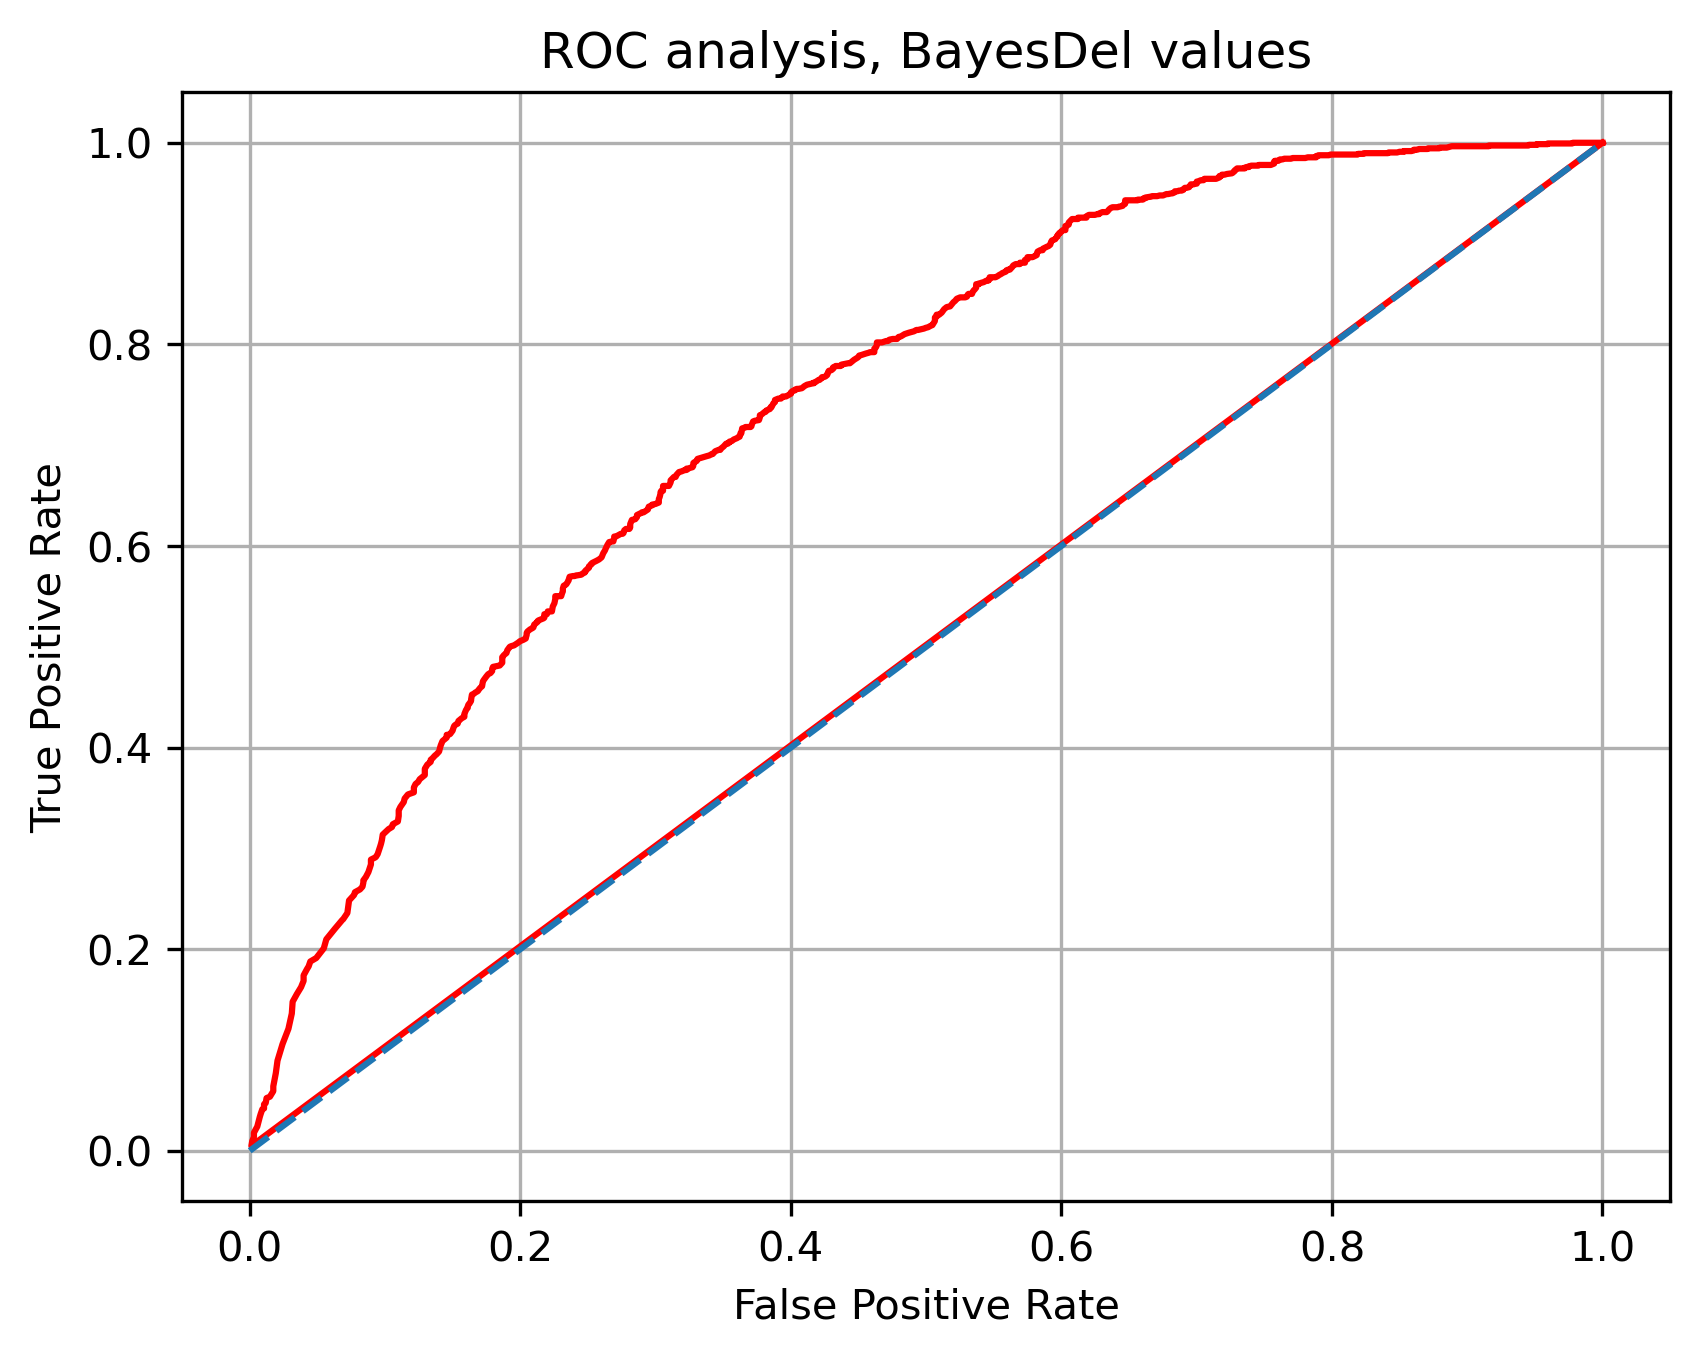

In [14]:
## Generate the data for a roc curve
predlist = []
roc_curvedata = []
for i in np.arange(-1.3,0.75, 0.001):
    pred = []
    for item in plotting_frame["BayesDel_noAF_score"]:
        predvalue = 1 if item >= i else 0 # This line determines which group everything is in-get it right!
        pred.append(predvalue)
    predlist.append(pred)
    fpr, tpr, _ = roc_curve(true_values, pred)
    roc_auc = auc(fpr, tpr)
    curvelist = [i, fpr[1], tpr[1], roc_auc]
    roc_curvedata.append(curvelist)
    
roc_dataframe = pd.DataFrame(roc_curvedata, columns=["threshold", "fpr", "tpr", "auc"])

fig,ax = plt.subplots()
g = plt.plot(roc_dataframe["fpr"], roc_dataframe["tpr"], c = "r")
g2 = plt.plot(np.arange(0,1.1, 0.1), np.arange(0,1.1,0.1), linestyle = "dashed")
#g.set_xlim(0,1)
#g.set_ylim(0,1.01)

plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC analysis, BayesDel values")

plt.grid()
#plt.savefig("Foldx_ROCcurve_v1.pdf")
plt.show()

In [15]:
with pd.option_context('display.max_rows', None, 'display.max_columns', None):  # more options can be specified also
    display(roc_dataframe.sort_values(by = "auc", ascending = False))

,threshold,fpr,tpr,auc
1608,3.080000e-01,0.388301,0.744842,0.678270
1674,3.740000e-01,0.317362,0.673315,0.677977
1607,3.070000e-01,0.390790,0.746217,0.677714
1659,3.590000e-01,0.331052,0.686382,0.677665
1675,3.750000e-01,0.315495,0.670564,0.677535
1677,3.770000e-01,0.313628,0.668501,0.677436
1673,3.730000e-01,0.319228,0.674003,0.677387
1609,3.090000e-01,0.388301,0.742779,0.677239
1661,3.610000e-01,0.328563,0.682944,0.677191
1604,3.040000e-01,0.393902,0.748281,0.677189


In [16]:
cutoff= 0.308

ds_calc_nofold = ds_calc[ds_calc["BayesDel_noAF_score"].astype(float)>=cutoff]
print("fraction of average_energy which agrees", len(ds_calc_nofold)/len(ds_calc)) 

bs_calc_nofold = bs_calc[bs_calc["BayesDel_noAF_score"].astype(float)<=cutoff] 
print("fraction benign that remain", len(bs_calc_nofold)/len(bs_calc))

fraction of average_energy which agrees 0.7448418156808804
fraction benign that remain 0.611698817672682


In [17]:
TN = len(bs_calc_nofold)
FP = len(ds_calc_nofold)
TP = len(ds_calc)-FP
FN = len(bs_calc)-TN

#accuracy = (TP+TN)/(TP+TN+FP+FN)
print("Accuracy:",(TP+TN)/(TP+TN+FP+FN)) #0.74 for 1.6, 0.77 for 2.5

#sensitivity = TP/(TP+FN)
print("Sensitivity:",TP/(TP+FN)) #0.65 for 1.6, 0.77 for 2.5

#specificity = TN/(TN+FP)
print("Specificity:",TN/(TN+FP)) #0.82 for 1.6, 0.77 for 2.5

Accuracy: 0.4423391048676903
Sensitivity: 0.37286432160804023
Specificity: 0.47579864472410455
